In [45]:
from src.utils.results_utils import *

from src.utils.data_utils import str_dict_to_values

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy import stats

In [61]:
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity.sample(10)

,Name,Central Europe,East Asia,Eastern Europe,Latin America,Middle East,Nordic,North Africa,North America,Oceania,Russia and Ex-USSR,South Asia,Southeast Asia,Sub-Saharan Africa,Western Europe
1410,Gete,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
98,Alam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
36,Adelinde,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3107,Olle,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2608,Manfred,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
441,Bartlomiej,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3625,Sergiusz,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1781,Ichiya,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2822,Mijain,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3478,Rotimi,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


In [57]:
region_counts = (df_ethnicity.iloc[:, 1:] != 0).sum()
region_counts.sort_values(ascending=False).head(14)

Western Europe        1363
Central Europe         760
North America          583
East Asia              487
Eastern Europe         470
Latin America          462
Russia and Ex-USSR     433
Nordic                 418
Oceania                404
Sub-Saharan Africa     155
South Asia             144
Middle East             96
Southeast Asia          59
North Africa            28
dtype: int64

In [58]:
def get_vowel_stats(df:pd.DataFrame):
    vowels = set('aeiouy')

    def count_vowels(name):
        return sum(1 for char in name.lower() if char in vowels)

    def count_consonants(name):
        return sum(1 for char in name.lower() if char not in vowels)

    df['vowel_count'] = df['Name'].apply(count_vowels)
    df['consonant_count'] = df['Name'].apply(count_consonants)

    stats_gender_vowels = df.groupby('Country')['vowel_count'].agg(['mean', 'std'])
    stats_gender_consonants = df.groupby('Country')['consonant_count'].agg(['mean', 'std'])
    return stats_gender_vowels, stats_gender_consonants

df_vowels, df_consonants = get_vowel_stats(df_ethnicity)

KeyError: 'Country'

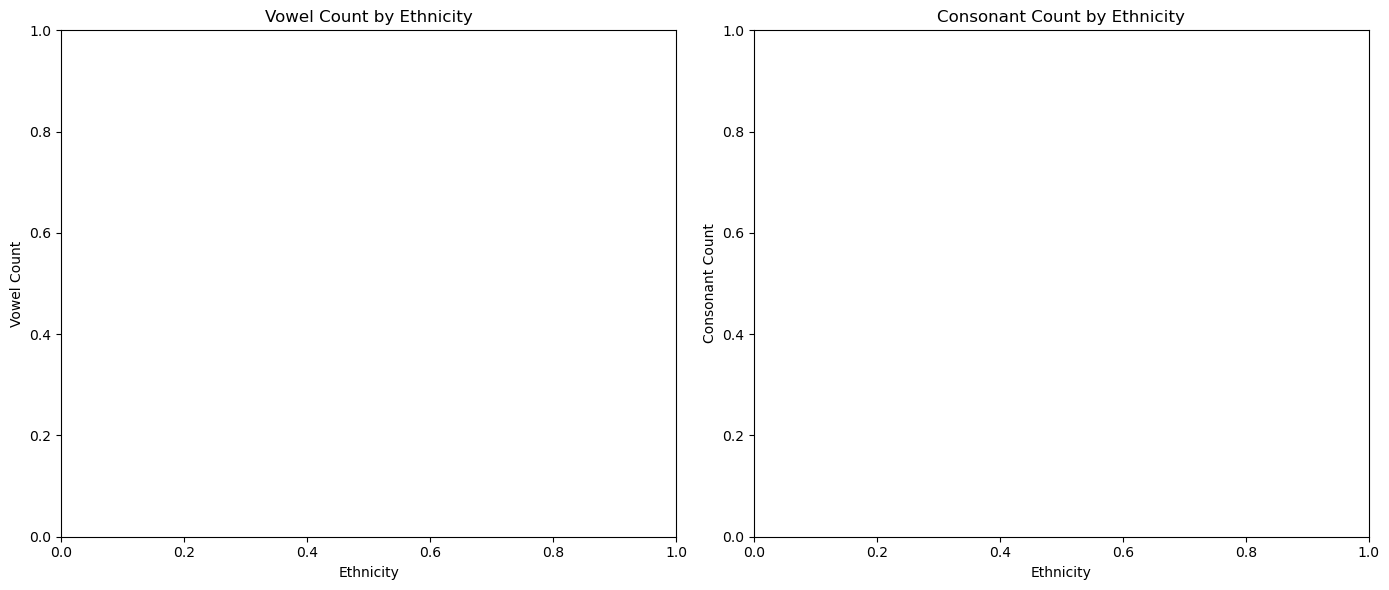

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for vowel count by sex
sns.boxenplot(data=df_ethnicity, x='Country', y='vowel_count', ax=axes[0])
axes[0].set_title('Vowel Count by Ethnicity')
axes[0].set_xlabel('Ethnicity')
axes[0].set_ylabel('Vowel Count')

# Boxplot for consonant count by Country
sns.boxenplot(data=df_ethnicity, x='Country', y='consonant_count', ax=axes[1])
axes[1].set_title('Consonant Count by Ethnicity')
axes[1].set_xlabel('Ethnicity')
axes[1].set_ylabel('Consonant Count')

plt.tight_layout()

In [ ]:
def get_length_stats(df:pd.DataFrame, column_name, column_groupby):
    df['name_length'] = df[column_name].apply(lambda name: len(name))
    stats_length = df.groupby(column_groupby)['name_length'].agg(['mean', 'std'])
    return stats_length

df_length = get_length_stats(df_ethnicity_f, column_name='Name', column_groupby='Country')

print('Length stats for names by ethnicity:')
df_length.head()

Length stats for names by ethnicity:


,mean,std
Country,,


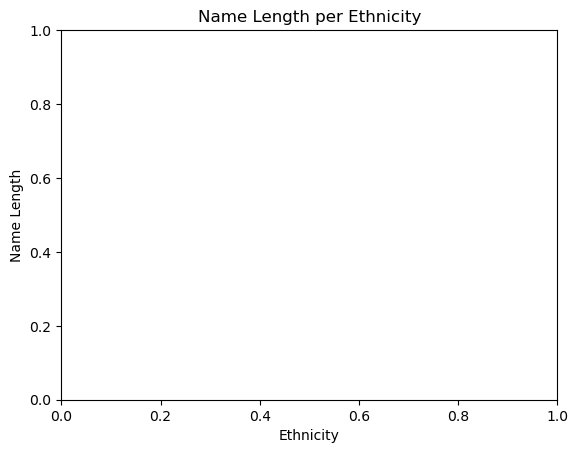

In [ ]:
def create_boxenplot_by_Country(data: pd.DataFrame, column_name, abcisse):
    data['name_length'] = data[column_name].apply(lambda name: len(name))

    fig = sns.boxenplot(data, x=abcisse, y='name_length')
    fig.set_xlabel('Ethnicity')
    fig.set_ylabel('Name Length')
    fig.set_title('Name Length per Ethnicity')

create_boxenplot_by_Country(df_ethnicity_f, column_name='Name', abcisse='Country')

In [ ]:
def create_letter_count_df(df, letter_position):

    df_letter = df.copy()
    df_letter['letter'] = df_letter['Name'].apply(lambda name: name[letter_position].lower())
    
    letter_counts_H = df_letter[df_letter['Country'] == 'ex-USSR']['letter'].value_counts()
    letter_counts_F = df_letter[df_letter['Country'] == 'British']['letter'].value_counts()

    male_count = df_letter[df_letter['Country'] == 'ex-USSR'].shape[0]
    female_count = df_letter[df_letter['Country'] == 'British'].shape[0]
    letter_counts_H_percentage = letter_counts_H / male_count*100
    letter_counts_F_percentage = letter_counts_F / female_count*100
    letter_counts = pd.concat([letter_counts_H_percentage, letter_counts_F_percentage], axis=1)
    letter_counts.columns = ['letter_men', 'letter_women']
    letter_counts = letter_counts.head(26)  # Limit to top 26 letters

    top_letter_names = (
        df_letter.groupby(['letter', 'Country'])['Name']
        .apply(lambda x: x.value_counts().head(3).index.tolist())
        .unstack(fill_value=[])
    )

    return letter_counts, top_letter_names

def plot_letter_name_percentage(df, letter_position, comparison):

    letter_counts, top_letter_names = create_letter_count_df(df, letter_position)

    if letter_position == 0:
        title = f'Percentage of Names Starting by Each Letter by {comparison}'
    else:
        title = f'Percentage of Names Ending by Each Letter by {comparison}'

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=letter_counts.index,
        y=letter_counts['letter_men'],
        name='ex-USSR',
        marker_color='salmon',
        hovertext=[f"Top names: {', '.join(top_letter_names.loc[letter, 'ex-USSR'])}" if 'ex-USSR' in top_letter_names.columns else "" for letter in letter_counts.index],
        hoverinfo="text"
    ))

    fig.add_trace(go.Bar(
        x=letter_counts.index,
        y=letter_counts['letter_women'],
        name='Brittish',
        marker_color='skyblue',
        hovertext=[f"Top names: {', '.join(top_letter_names.loc[letter, 'British'])}" if 'British' in top_letter_names.columns else "" for letter in letter_counts.index],
        hoverinfo="text"
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Letter of the Name',
        yaxis_title='% of Total Names by Ethnicity',
        barmode='group',
        yaxis=dict(ticksuffix='%'),
        legend_title="Ethnicity"
    )

    fig.show()

plot_letter_name_percentage(df_ethnicity_f, 0, comparison='Country')
plot_letter_name_percentage(df_ethnicity_f, -1, comparison='Country')
